# Knet.jl

Knet (произносится «kay-net») - это система глубокого обучения Университета Коч, внедренная в Julia Денизом Юретом и его сотрудниками. Knet поддерживает работу с графическим процессором и автоматическое дифференцирование с использованием динамических вычислительных графиков для моделей, выполненных чисто на Джулии.

* [Страница проекта](https://github.com/denizyuret/Knet.jl)
* [Установка и документация](https://denizyuret.github.io/Knet.jl/latest/install/)
* [Примеры и оригинал туториала](https://github.com/denizyuret/Knet.jl/tree/master/examples)

Если хочется задействовать видеокарту, внимательно почитайте руководство, установите необходимые средства *Visual Studio* и ~~попляшите с бубном~~, выполнив все необходимые настройки, приступайте к оригинальному туториалу: 
```julia
julia> using Pkg; Pkg.add("IJulia"); Pkg.add("Knet")
julia> using IJulia, Knet
julia> notebook(dir=Knet.dir("tutorial"))
```
(он будет доступен в содержимом пакета Knet), ну а здесь мы будем греть только процессор.

## Загрузка и мини-пакет данных MNIST
(c) Deniz Yuret, 2019
* Мы будем загружать [MNIST](http://yann.lecun.com/exdb/mnist), конвертируем данные в матрицы, раскидаем на типы данных: [minibatch](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.minibatch) и  [Data](https://github.com/denizyuret/Knet.jl/blob/master/src/data.jl)
* Предпосылки: [Julia массивы](https://docs.julialang.org/en/v1/manual/arrays)
* Новые функции: [dir](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.dir), [minibatch, Data](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.minibatch), [mnist, mnistview](https://github.com/denizyuret/Knet.jl/blob/master/data/mnist.jl)

Мы создадим модели классификации для набора данных распознавания рукописных цифр MNIST. MNIST имеет 60000 учебных и 10000 тестовых примеров. Каждый вход x состоит из 784 пикселей, представляющих изображение 28x28. Соответствующий вывод указывает идентичность цифры 0..9.

![](http://yann.lecun.com/exdb/lenet/gifs/asamples.gif "MNIST")

[image source](http://yann.lecun.com/exdb/lenet)

In [1]:
# Загрузка пакетов, импорт символов
using Pkg; for p in ("Knet","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir, minibatch, Data

In [ ]:
?haskey

In [3]:
# загружает набор данных распознавания рукописных цифр MNIST:
include(Knet.dir("data","mnist.jl")) # Knet.dir создает путь относительно корня Knet
xtrn,ytrn,xtst,ytst = mnist()        # mnist() загружает данные MNIST и преобразует их в массивы Julia
println.(summary.((xtrn,ytrn,xtst,ytst)));

┌ Info: Loading MNIST...
└ @ Main C:\Users\User\.julia\packages\Knet\T1oum\data\mnist.jl:33


28×28×1×60000 Array{Float32,4}
60000-element Array{UInt8,1}
28×28×1×10000 Array{Float32,4}
10000-element Array{UInt8,1}


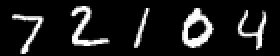

In [4]:
# mnistview(x,i) преобразует i-й экземпляр из х в изображение
# Вот первые пять изображений из тестового набора:
using Images
hcat([mnistview(xtst,i) for i=1:5]...)

In [5]:
# Вот их метки (10 используется для обозначения 0)
println(Int.(ytst[1:5]));

[7, 2, 1, 10, 4]


In [6]:
# `minibatch` разбивает тензоры данных на небольшие фрагменты, называемые минибатчи.
# Возвращает структуру Knet.Data: итератор пар (x, y).
dtrn = minibatch(xtrn,ytrn,100) # тренировочные
dtst = minibatch(xtst,ytst,100) # тестовые

Data{Tuple{Array{Float32,4},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 100, 10000, false, 9901, 1:10000, false, (28, 28, 1, 10000), (10000,), Array{Float32,4}, Array{UInt8,1})

In [7]:
# Каждый минибатч представляет собой пару (x, y), где x - это 100 (28x28x1) изображений,
# а y - соответствующие 100 меток.
# Вот первая мини-партия в тестовом наборе:
(x,y) = first(dtst)
println.(summary.((x,y)));

28×28×1×100 Array{Float32,4}
100-element Array{UInt8,1}


In [8]:
# Итераторы могут использоваться в циклах for, например `for (x, y) in dtrn`
# dtrn генерирует 600 мини-пакетов из 100 изображений (всего 60000)
# dtst генерирует 100 мини-пакетов из 100 изображений (всего 10000)
n = 0
for (x,y) in dtrn
    n += 1
end
n

600

## Итераторы
(c) Deniz Yuret, 2019

* Цель: научиться создавать и использовать итераторы Юлии.
* Чтиво: [Interfaces](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-iteration-1),  [Collections](https://docs.julialang.org/en/v1/base/collections/#lib-collections-iteration-1), [Iteration Utilities](https://docs.julialang.org/en/v1/base/iterators) and [Generator expressions](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions-1) in the Julia manual.
* Новые функции: 
[first](https://docs.julialang.org/en/v1/base/collections/#Base.first), 
[collect](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Any}), 
[repeat](https://docs.julialang.org/en/v1/base/arrays/#Base.repeat), 
[take](https://docs.julialang.org/en/v1/base/iterators/#Base.Iterators.take), 
[drop](https://docs.julialang.org/en/v1/base/iterators/#Base.Iterators.drop), 
[cycle](https://docs.julialang.org/en/v1/base/iterators/#Base.Iterators.cycle), 
[Stateful](https://docs.julialang.org/en/v1/base/iterators/#Base.Iterators.Stateful), 
[iterate](https://docs.julialang.org/en/v1/base/collections/#lib-collections-iteration-1)

Функция `minibatch` возвращает объект `Knet.Data`, реализованный в виде итератора Julia, который генерирует (x, y) минибатчи. Итераторы - это ленивые объекты, которые генерируют свой следующий элемент только по запросу. Преимущество этого состоит в том, что вы не тратите время и память, пытаясь создать и сохранить все элементы одновременно.
У нас даже могут быть бесконечные итераторы! Алгоритмы обучения в Knet также реализованы как итераторы, так что:
1. Мы можем отслеживать и сообщать о потере обучения
2. Мы можем сделать снимки модели во время обучения
3. Мы можем приостановить / прекратить обучение при необходимости

Вот что Джулия может делать с итераторами:

In [9]:
# Установить ширину дисплея, импортировать символы
ENV["COLUMNS"]=72
using Base.Iterators: take, drop, cycle, Stateful
using Knet

In [10]:
# Мы можем посмотреть на первый элемент, используя first()
summary.(first(dtst))

("28×28×1×100 Array{Float32,4}", "100-element Array{UInt8,1}")

In [ ]:
?summary

In [12]:
# Итераторы могут быть использованы для циклов
# Давайте посчитаем элементы в dtst:
n = 0
for (x,y) in dtst; n += 1; end
@show n;

n = 100


In [13]:
# Итераторы могут быть преобразованы в массивы с помощью `collect`
# (не делайте это без необходимости, это просто тратит впустую память. Вместо этого используйте цикл for)
collect(dtst) |> summary

"100-element Array{Tuple{Array{Float32,4},Array{UInt8,1}},1}"

In [14]:
# Мы можем сгенерировать итератор для нескольких эпох, используя `repeat`
# (эпоха - это один проход по набору данных)
n = 0
for (x,y) in repeat(dtst,5); n += 1; end
@show n;

n = 500


In [15]:
# Мы можем генерировать частичные эпохи, используя `take`, который берет первые n элементов
n = 0
for (x,y) in take(dtst,20); n += 1; end
@show n;

n = 20


In [16]:
# Мы также можем генерировать частичные эпохи с помощью `drop`, который удаляет первые n элементов
n = 0
for (x,y) in drop(dtst,20); n += 1; end
@show n;

n = 80


In [18]:
# Мы можем вечно повторять, используя `cycle` (это полезно для тренировки до схождения)
# Вы не хотите собирать цикл или запускать цикл без break! 
n = 0; t = time_ns()
for (x,y) in cycle(dtst)
    n += 1
    time_ns() - t > 2e9 && break # Break after 2 seconds
end
@show n;

n = 10424


In [ ]:
?time_ns

In [23]:
# Мы можем сделать итератор Stateful, чтобы он запомнил, где он остановился.
# (по умолчанию итераторы начинаются с начала)
dtst1 = dtst            # dtst1 будет начинаться с начала каждый раз
dtst2 = Stateful(dtst)  # dtst2 продолжит с места остановки
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end

[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[6, 10, 5, 4, 9]


In [24]:
# Мы можем перемешивать экземпляры в каждую эпоху, используя ключевое слово аргумент `shuffle = true`
# (по умолчанию элементы генерируются в том же порядке)
dtst1 = minibatch(xtst,ytst,100)              # dtst1 повторяется в том же порядке
dtst2 = minibatch(xtst,ytst,100,shuffle=true) # dtst2 тасует каждый раз
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end

[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[3, 1, 4, 3, 4]
[5, 8, 4, 6, 1]


Мы можем создавать новые итераторы, используя [генератор выражений](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions-1)

В следующем примере создается итератор по нормам x в наборе данных:

In [25]:
xnorm(data) = (sum(abs2,x) for (x,y) in data)
collect(xnorm(dtst))'

1×100 LinearAlgebra.Adjoint{Float32,Array{Float32,1}}:
 7990.35  7842.33  8162.68  7692.77  …  8494.0  7361.33  8643.01

In [26]:
# Каждый итератор реализует функцию `iterate`, которая возвращает
# следующий элемент и состояние (или ничего, если не осталось элементов).
# Вот как реализован цикл for для dtst:
n = 0; next = iterate(dtst)
while next != nothing
    ((x,y), state) = next
    n += 1
    next = iterate(dtst,state)
end
@show n;

n = 100


In [27]:
# Вы можете определить свой собственный итератор, объявив новый тип и переопределив метод `iterate`.
# Вот еще один способ определить итератор по нормам x в наборе данных:
struct Xnorm; itr; end

function Base.iterate(f::Xnorm, s...)
    next = iterate(f.itr, s...)
    next === nothing && return nothing
    ((x,y),state) = next
    return sum(abs2,x), state
end

Base.length(f::Xnorm) = length(f.itr) # collect needs this

collect(Xnorm(dtst))'

1×100 LinearAlgebra.Adjoint{Any,Array{Any,1}}:
 7990.35  7842.33  8162.68  7692.77  …  8494.0  7361.33  8643.01